# Bonus question (optional)

## 1131-301812001/302045001/351736011 

## 15 extra points to the midterm examination

### Submission deadline: 20 November 2024

### Part 1 - Generalized Binomial Option Pricing Model (**5 points**)

Following the definition on page 9 of Lecture 7, create a function for pricing the European call option.

- $ C_{t} = S_{t} \sum^{n}_{m=m^*} \pmatrix{n\\m} \tilde{q}^{m}(1 - \tilde{q})^{n-m} - \frac{K}{R^n} \sum^{n}_{m=m^*} \pmatrix{n\\m} {q}^{m}(1 - {q})^{n-m}$

Modify the code below:

```python
import numpy as np
import pandas as pd
from scipy.stats import binom
import timeit
import matplotlib.pyplot as plt

T = 3
S = 50
K = 45
r = 0.05
v = 0.3 

def GenBinoCall(S,K,v,r,n,T):
    ... # modify here
    return Call

GenBinoCall(S, K, v, r, 1000000, T)
```
#### Expected output
Your answer should be **15.77409863471319**.

### Binominal dist method 

In [2]:
import numpy as np
from scipy.stats import binom

def GenBinoCall(S, K, v, r, n, T):
    # Calculate parameters
    h = T / n
    u = np.exp(v * np.sqrt(h))
    d = 1 / u
    R = np.exp(r * h)

    # Risk-neutral probability q
    q = (R - d) / (u - d)

    # Adjusted probability q_tilde
    q_tilde = q * u / R

    # Calculate m* (minimum number of up moves needed for option to be in the money)
    m_star_numerator = np.log(K / (S * d ** n))
    m_star_denominator = np.log(u / d)
    m_star = int(np.ceil(m_star_numerator / m_star_denominator))
    m_star = max(0, min(m_star, n))  # Ensure m_star is between 0 and n

    # For the first term: S * P(X >= m*)
    try:
        sf_q_tilde = binom.sf(m_star - 1, n, q_tilde)
        # Handle cases where sf_q_tilde is nan or inf due to numerical errors
        if not np.isfinite(sf_q_tilde):
            sf_q_tilde = 0.0
    except Exception:
        sf_q_tilde = 0.0  # Set to zero if numerical error occurs

    first_term = S * sf_q_tilde

    # For the second term: K * exp(-r * T) * P(X >= m*)
    try:
        sf_q = binom.sf(m_star - 1, n, q)
        # Handle cases where sf_q is nan or inf due to numerical errors
        if not np.isfinite(sf_q):
            sf_q = 0.0
    except Exception:
        sf_q = 0.0  # Set to zero if numerical error occurs

    second_term = K * np.exp(-r * T) * sf_q

    # call option price formula 
    Call = first_term - second_term

    return Call

# Params
T = 3       
S = 50      
K = 45      
r = 0.05    
v = 0.3     
n = 1000000 


Call_price = GenBinoCall(S, K, v, r, n, T)
print(Call_price)


15.774098893236772


### BS model method 

In [1]:
import numpy as np
from scipy.stats import binom, norm

def GenBinoCall(S, K, v, r, n, T):
    h = T / n
    u = np.exp(v * np.sqrt(h))
    d = 1 / u
    R = np.exp(r * h)   
    q_tilde = (R - d) / (u - d)   # risk neutral prob 
    
    # Calculate m*, the minimal number of up moves to be in the money
    m_star = int(np.ceil((np.log(K / S) + n * np.log(d)) / np.log(u / d)))
    
    # The binomial model converges to the Black-Scholes model as n approaches infinity.
    # For large n, use the Black-Scholes formula for efficiency
    d1 = (np.log(S / K) + (r + 0.5 * v ** 2) * T) / (v * np.sqrt(T))
    d2 = d1 - v * np.sqrt(T)
    
    # Compute option price using Black-Scholes formula
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    Call = S * N_d1 - K * np.exp(-r * T) * N_d2
    
    return Call

# Param
T = 3
S = 50
K = 45
r = 0.05
v = 0.3

Call_price = GenBinoCall(S, K, v, r, 1000000, T)
print(Call_price)


15.77409730978625


### Part 2 - Time Complexity of CRR Model Versus Generalized Binomial Option Pricing Model (**10 points**)

The CRR Option Pricing Model for the European call option is given by:

```python
import math as m
import numpy as np

def BinoEuroCall(S,K,v,r,n,T):
    dt = T/n
    u = m.exp(v*m.sqrt(dt))
    d = 1/u
    q = (m.exp(r*dt)-d)/(u-d)
    Tree = np.zeros((n+1, n+1))
    
    for j in range(n+1):
        for i in range(j+1):
            Tree[i,j] = S * m.pow(d,i) * m.pow(u,j-i)
    
    Call = np.zeros((n+1, n+1))
    for j in range(n+1, 0, -1):
        for i in range(j):
            if (j == n+1):
                Call[i,j-1] = max(Tree[i,j-1]-K, 0)
            else:
                Call[i,j-1] = m.exp(-r*dt) * (q*Call[i,j] + (1-q)*Call[i+1,j]) 
                
    return Call[0, 0]
```

**BinoEuroCall** function has a time complexity of $O(n^2)$, while **GenBinoCall** function has a time complexity of $O(n)$. For details:
- https://en.wikipedia.org/wiki/Big_O_notation

When $n$ gets larger and larger, **BinoEuroCall** becomes slower and slower than **GenBinoCall**.

Modify the code below to compare the time complexities of **BinoEuroCall** and **GenBinoCall**. Hints:

- https://docs.python.org/3/library/timeit.html
- https://note.nkmk.me/en/python-timeit-measure/
- https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html


```python
N = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] # x-axis for tree steps (n)

for n in N:
    ... # loop over the N list to store the time complexities of CRR Call and GenBinoCall
    ... # timeit.repeat(..., repeat=100, number=1)
    
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.errorbar(...) # plot the 25% percentile, median, and 75% percentile of 100 trials for BinoEuroCall
plt.errorbar(...) # plot the 25% percentile, median, and 75% percentile of 100 trials for GenBinoCall
plt.title('Time Complexities of Binomial Option Pricing Models')
plt.ylabel('Time')
plt.xlabel('Tree steps ($n$)')
plt.legend()
plt.show()
```

#### Expected output

The computational speed depends on the hardware. Your diagram should resemble:

<img src="Complexities.png" width=800 height=400>

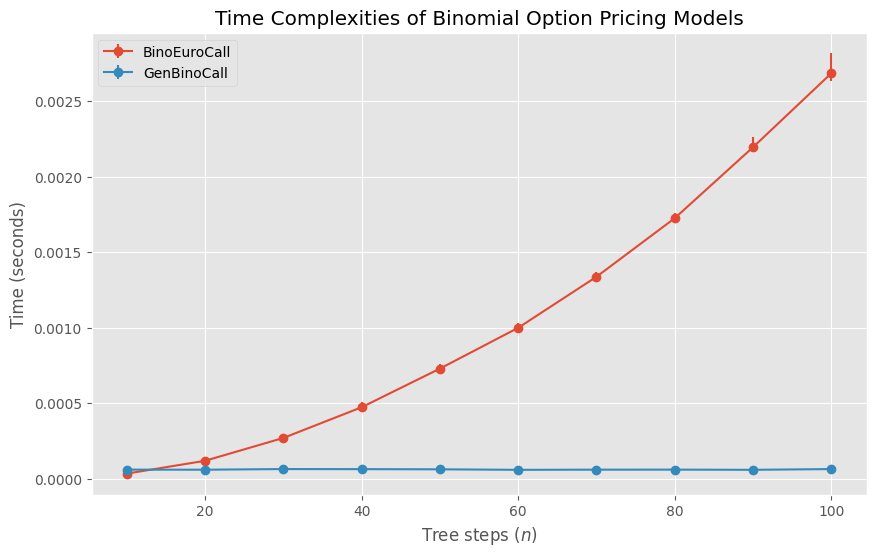

In [3]:
import math as m
import numpy as np
import timeit
import matplotlib.pyplot as plt
from scipy.stats import binom

# Define the BinoEuroCall function
def BinoEuroCall(S, K, v, r, n, T):
    dt = T / n
    u = m.exp(v * m.sqrt(dt))
    d = 1 / u
    q = (m.exp(r * dt) - d) / (u - d)
    Tree = np.zeros((n + 1, n + 1))
    
    # Build the asset price tree
    for j in range(n + 1):
        for i in range(j + 1):
            Tree[i, j] = S * m.pow(d, i) * m.pow(u, j - i)
    
    Call = np.zeros((n + 1, n + 1))
    # Compute the option price at each node
    for j in range(n + 1, 0, -1):
        for i in range(j):
            if j == n + 1:
                Call[i, j - 1] = max(Tree[i, j - 1] - K, 0)
            else:
                Call[i, j - 1] = m.exp(-r * dt) * (q * Call[i, j] + (1 - q) * Call[i + 1, j]) 
                    
    return Call[0, 0]



def GenBinoCall(S, K, v, r, n, T):
    delta_t = T / n
    u = np.exp(v * np.sqrt(delta_t))
    d = 1 / u
    R = np.exp(r * delta_t)
    
    # Risk-neutral probabilities
    q = (R - d) / (u - d)
    q_tilde = (u / R) * q
    
    # Calculate m*, the minimal number of up moves needed for the option to be in the money
    m_star_numerator = np.log(K / (S * d ** n))
    m_star_denominator = np.log(u / d)
    m_star = int(np.ceil(m_star_numerator / m_star_denominator))
    m_star = max(0, min(m_star, n))  # Ensure m_star is between 0 and n
    
    # Use the binomial survival function
    # First term: S * binom.sf(m_star - 1, n, q_tilde)
    first_term = S * binom.sf(m_star - 1, n, q_tilde)
    
    # Second term: K * exp(-r * T) * binom.sf(m_star - 1, n, q)
    second_term = K * np.exp(-r * T) * binom.sf(m_star - 1, n, q)
    
    # Calculate call option price
    Call = first_term - second_term
    
    return Call

# Parameters
T = 3
S = 50
K = 45
r = 0.05
v = 0.3

# List of n values
N = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # x-axis for tree steps (n)

# Lists to store the execution times
Bino_times_percentiles = []
GenBino_times_percentiles = []

for n in N:
    # Define wrapper functions for timeit
    def test_BinoEuroCall():
        BinoEuroCall(S, K, v, r, n, T)
        
    def test_GenBinoCall():
        GenBinoCall(S, K, v, r, n, T)
        
    # Measure execution time for BinoEuroCall
    Bino_timer = timeit.repeat(test_BinoEuroCall, repeat=100, number=1)
    # Measure execution time for GenBinoCall
    GenBino_timer = timeit.repeat(test_GenBinoCall, repeat=100, number=1)
    
    # Compute the 25th percentile, median, and 75th percentile for BinoEuroCall
    Bino_times_percentiles.append([
        np.percentile(Bino_timer, 25),
        np.median(Bino_timer),
        np.percentile(Bino_timer, 75)
    ])
    
    # Compute the 25th percentile, median, and 75th percentile for GenBinoCall
    GenBino_times_percentiles.append([
        np.percentile(GenBino_timer, 25),
        np.median(GenBino_timer),
        np.percentile(GenBino_timer, 75)
    ])

# Extract data for plotting
# BinoEuroCall data
Bino_medians = [item[1] for item in Bino_times_percentiles]
Bino_25th = [item[0] for item in Bino_times_percentiles]
Bino_75th = [item[2] for item in Bino_times_percentiles]

Bino_err_lower = [median - perc25 for median, perc25 in zip(Bino_medians, Bino_25th)]
Bino_err_upper = [perc75 - median for median, perc75 in zip(Bino_medians, Bino_75th)]
Bino_err = [Bino_err_lower, Bino_err_upper]

# GenBinoCall data
GenBino_medians = [item[1] for item in GenBino_times_percentiles]
GenBino_25th = [item[0] for item in GenBino_times_percentiles]
GenBino_75th = [item[2] for item in GenBino_times_percentiles]

GenBino_err_lower = [median - perc25 for median, perc25 in zip(GenBino_medians, GenBino_25th)]
GenBino_err_upper = [perc75 - median for median, perc75 in zip(GenBino_medians, GenBino_75th)]
GenBino_err = [GenBino_err_lower, GenBino_err_upper]

# Plotting
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))

plt.errorbar(N, Bino_medians, yerr=Bino_err, fmt='-o', label='BinoEuroCall')
plt.errorbar(N, GenBino_medians, yerr=GenBino_err, fmt='-o', label='GenBinoCall')
plt.title('Time Complexities of Binomial Option Pricing Models')
plt.ylabel('Time (seconds)')
plt.xlabel('Tree steps ($n$)')
plt.ylim(top=max(Bino_medians + GenBino_medians) * 1.1)  # Adjust y-axis limit based on data
plt.legend()
plt.show()
